In [1]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/MyDrive/ECG_Classification_Pytorch-master/raw_data')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import torch
import torch.nn as nn

import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ecg_record = wfdb.rdrecord('14046', channels= [0])
# ecg_record.fs 

In [5]:
ecg_record = wfdb.rdrecord('14046', sampfrom= 0, sampto= 108300, channels= [1])

In [6]:
ecg = ecg_record.p_signal[:,0]
train_len = 108000

ecg_train = ecg[0: train_len]
ecg_test = ecg[train_len:]

In [7]:
ecg_train = torch.FloatTensor(ecg_train).view(-1)

In [8]:
ecg_test = torch.FloatTensor(ecg_test).view(-1)

In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq   

In [10]:


def create_dataloader(data_entered, train_window, batch_size):
  data = create_inout_sequences(data_entered, train_window)
  data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last= True)
  return data_loader



In [11]:


train_window = 850  # 3 cardiac cycles in each sequence
# train_data = create_inout_sequences(ecg_train, train_window)
batch_size = 64



In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_dim=100, n_layers=5, output_size=1, drop_prob=0.5, lr=0.001):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.lr = lr

        ## define the LSTM
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers= n_layers, dropout=drop_prob, batch_first=True)
        
        ## define a dropout layer
        self.dropout = nn.Dropout(drop_prob)

        ## define the final, fully-connected output layer
        self.linear = nn.Linear(hidden_dim, output_size)


    def forward(self, input_seq, hidden):
        lstm_out, hidden = self.lstm(input_seq, hidden)
        out = self.dropout(lstm_out)
        out = out.contiguous().view(-1, self.hidden_dim)

        #fully-connected layer
        out = self.linear(out)

        batch_size = input_seq.size(0)
        
        # return the final output and the hidden state
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

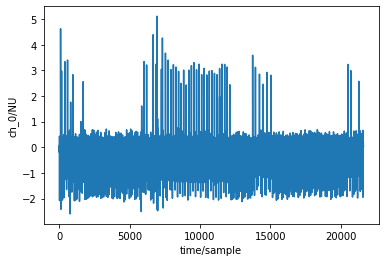

In [13]:
ecg_val = wfdb.rdrecord('14046', sampfrom= 108300, sampto= 129900, channels= [0])
ecg_val = ecg_val.p_signal[:,0]

wfdb.plot_items(ecg_val)
ecg_val = torch.FloatTensor(ecg_val).view(-1)

seq_length = train_window
train_data_loader = create_dataloader(ecg_train, seq_length, batch_size)
val_data_loader = create_dataloader(ecg_val, seq_length, batch_size)

In [14]:
def train(net, train_data_loader, val_data_loader, epochs=20, batch_size=batch_size, lr=0.1, clip=5, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: LSTM network
        data: ecg data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.L1Loss()
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    for e in range(epochs):
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in train_data_loader:
            counter += 1
            x = torch.unsqueeze(x, 2)

            inputs, targets = x, y
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size).long())
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in val_data_loader:
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])

                    x = torch.unsqueeze(x, 2)

                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size).long())
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [15]:
hidden_dim=32
n_layers=3

net = LSTM(hidden_dim= hidden_dim, n_layers= n_layers)
print(net)

LSTM(
  (lstm): LSTM(1, 32, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
batch_size = 64
seq_length = train_window
n_epochs = 1

# model training
# train(net, ecg_train, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

train(net, train_data_loader, val_data_loader, epochs=n_epochs, batch_size=batch_size, lr=0.25, print_every=10)

Epoch: 1/1... Step: 10... Loss: 1.6030... Val Loss: 0.5116
Epoch: 1/1... Step: 20... Loss: 0.7654... Val Loss: 0.3311
Epoch: 1/1... Step: 30... Loss: 0.4135... Val Loss: 0.4355
Epoch: 1/1... Step: 40... Loss: 0.2582... Val Loss: 0.2965
Epoch: 1/1... Step: 50... Loss: 0.5618... Val Loss: 0.2502
Epoch: 1/1... Step: 60... Loss: 0.5954... Val Loss: 0.2096
Epoch: 1/1... Step: 70... Loss: 0.4923... Val Loss: 0.3055
Epoch: 1/1... Step: 80... Loss: 0.7286... Val Loss: 0.4846
Epoch: 1/1... Step: 90... Loss: 0.3181... Val Loss: 0.3205
Epoch: 1/1... Step: 100... Loss: 0.4385... Val Loss: 0.1352
Epoch: 1/1... Step: 110... Loss: 0.9196... Val Loss: 0.4907
Epoch: 1/1... Step: 120... Loss: 0.3138... Val Loss: 0.4095
Epoch: 1/1... Step: 130... Loss: 0.4547... Val Loss: 0.5106
Epoch: 1/1... Step: 140... Loss: 1.2186... Val Loss: 0.8091
Epoch: 1/1... Step: 150... Loss: 0.4787... Val Loss: 0.5484
Epoch: 1/1... Step: 160... Loss: 0.2673... Val Loss: 0.1728
Epoch: 1/1... Step: 170... Loss: 0.3021... Val Lo

In [ ]:
model_name = 'rnn_10_epoch.net'

checkpoint_20E = {'n_hidden': net.hidden_dim,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict()}

with open(model_name, 'wb') as f:
    torch.save(checkpoint_20E, f)